# Langevin Dynamics #


In lecture this week, we introduced the concept of *macroscopic* observables: ensemble averages of microscopic observables over all microstates consistent with a given set of macroscopic constraints. Modeling macroscopic properties numerically can be taxing. In principle, we *could* try to calculate the bulk properties of a glass of water using a macroscopic number ($\sim10^{23}$) of particles, but in practice real computers can't even store all the necessary data, let alone run the simulation. 

### MD Thermostats ###

To get around this problem, computational chemists have constructed a variety of methods designed to run an MD simulation with a *small* number of particles that behave as though they're interacting with a much larger number of particles. MD *thermostats*, for example, stabilize the average kinetic energy of particles in an MD simulation -- a proxy for the macroscopic temperature. Similarly, *barostats* stabilize the average pressure exerted by the particles running into the simulation box walls. In this exercise, we'll implement a simple thermostat using *Langevin dynamics*, an extension of molecular dynamics in which each particle feels (in addition to forces from other simulation particles) randomly-generated forces that simulate interaction with a large number of "solvent" particles whose microscopic coordinates aren't explicitly included in the simulation. 

### Langevin Dynamics for Solvation ###

Langevin dynamics originated in the study of Brownian motion -- the diffusion of mesoscopic particles (like pollen grains) in a solvent. A key assumption in the Langevin treatment is that the solvent particle is much larger than the solute molecules around it. As a result of that difference in scale, a careful theory can be worked out that allows us to explicitly follow the coordinates and momenta of the solute molecule, while treating the solvent molecules implicitly through their influence on the solvent particles. For a single solute particle, the Langevin equation reads
\begin{align}
M \ddot {\bf r}(t) &= {\bf F}({\bf r},t) - \gamma \dot {\bf r} + {\bf \xi}(t).
\end{align}
In the absence of the last two terms, this would simply be Newton's equation: ${\bf F} = M {\bf a}$. Here ${\bf F}({\bf r},t)$ is the deterministic force (if any) the particle would feel in the absence of interactions with the solvent. The last two terms represent (in an approximate way) the impact of the solvent on the solute dynamics. The $- \gamma \dot {\bf r}$ is proportional to the particle velocity ${\bf v} = - \gamma \dot {\bf r}$ and describes the *viscous drag* or friction that the solute particle experiences as a result of constantly running into solvent molecules. The second term, ${\bf \xi}(t)$ is a random force that represents the constantly-fluctuating force exerted on the particle by the surrounding solvent: sometimes the particle gets "kicked" up, sometimes down, sometimes left, sometimes right, all depending on the microscopic trajectories of the solvent molecules around it. Since we don't want to actually *calculate* all those microscopic solvent trajectories, the force ${\bf \xi}(t)$ in our simulation will be a random variable. Because the microscopic configuration of the solvent is assumed to change much more quickly than the position of the solute particle, the random force ${\bf \xi}(t)$ is taken to be *delta-correlated*, i.e., the value of the force at different time points $t_1$ and $t_2$ are assumed to be statistically independent of each other. For thermodynamic consistency, it can then be shown that the random force must satisfy the *fluctuation-dissipation relation* 
\begin{align}
\left \langle {\bf \xi}(t_2) {\bf \xi}(t_1) \right \rangle = 2 \gamma k_B T \delta(t_2 - t_1)
\end{align}
for any two time points $t_1$ and $t_2$. Of course, the assumption of a delta-correlated random force is an approximation. In the real world, there should always be *some* time scale (perhaps very short) over which the solvent forces remain correlated at different time points. For this reason, a key limitation to Langevin dynamics is that we only study dynamics on time scales *much longer* than this solvent correlation time. 

The numerical implementation of Langevin dynamics is slightly more complicated than plain-vanilla MD (mostly due to the appearance of the delta function in the noise correlation). For this simulation, we'll use an adapted Velocity-Verlet like algorithm published here: *Molecular Physics*, **111**, 983–991 (2013). You aren't responsible for understanding or coding the algorithm -- you'll just have to run the code -- although as usual you're encouraged to have a look anyway. Areas with major changes are marked by comment headings. After looking through the code, modify parameters to answer the questions in the text below it. 

In [1]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets

import numpy as np

from IPython.display import Javascript, display
from ipywidgets import widgets
import IPython.display as ipd



def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

gamma_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=100,
    step=1.0,
    description='$\gamma$ (pg/s):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
    
temp_slider = widgets.FloatSlider(
    value=300,
    min=0,
    max=1000,
    step=1.0,
    description='T (K):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

emax_slider = widgets.FloatSlider(
    value=10,
    min=0,
    max=100,
    step=1.0,
    description='$E_{max}\cdot 10^{-4}$ (statV/cm):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tmax_slider = widgets.FloatSlider(
    value=3,
    min=0,
    max=20,
    step=1.0,
    description='$t_{max}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tpulse_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=20,
    step=0.5,
    description='$t_{pulse}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)


npos_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=50,
    step=1,
    description='N$_{pos}$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


nneg_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=50,
    step=1,
    description='N$_{neg}$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

    
button = widgets.Button(description="Go!")
button.on_click(run_all)
# display(phase_slider)
# display(freq_slider)
# display(tau_slider)
display(npos_slider)
display(nneg_slider)
display(tmax_slider)
display(tpulse_slider)
display(gamma_slider)
display(temp_slider)
display(emax_slider)
display(button)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=15, continuous_update=False, description='N$_{pos}$', max=50)

IntSlider(value=15, continuous_update=False, description='N$_{neg}$', max=50)

FloatSlider(value=3.0, continuous_update=False, description='$t_{max}$ (ps)', max=20.0, readout_format='.0f', …

FloatSlider(value=0.5, continuous_update=False, description='$t_{pulse}$ (ps)', max=20.0, readout_format='.1f'…

FloatSlider(value=0.0, continuous_update=False, description='$\\gamma$ (pg/s):', readout_format='.0f', step=1.…

FloatSlider(value=300.0, continuous_update=False, description='T (K):', max=1000.0, readout_format='.0f', step…

FloatSlider(value=10.0, continuous_update=False, description='$E_{max}\\cdot 10^{-4}$ (statV/cm):', readout_fo…

Button(description='Go!', style=ButtonStyle())

In [2]:
gamma = gamma_slider.value*1e-12  # grams/second
Temp = temp_slider.value          # K
Emax = emax_slider.value*1e+4   # Maximum electric field in statV/cm
tmax = tmax_slider.value*1e-12      # Total simulation time in seconds
tpulse = tpulse_slider.value*1e-12      # Total simulation time in seconds
Npos = npos_slider.value
Nneg = nneg_slider.value
dt=1e-15     # Time-step in seconds
tmax = tmax_slider.value*1e-12


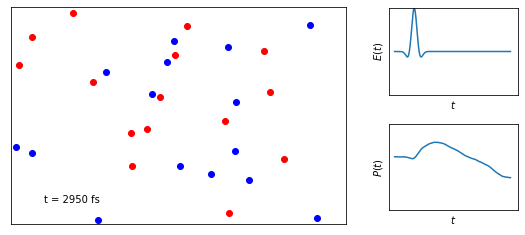

In [3]:
def calc_accel(x,y,efield):
    Minv = 1/M
    
    ax = 4*epso*(Ro**4)*Minv/(x**5) - 4*epso*Minv*(Ro**4)/((L-x)**5)
    ay = 4*epso*(Ro**4)*Minv/(y**5) - 4*epso*Minv*(Ro**4)/((L-y)**5)

    # X differences: Rx[m,n] is the x-displacement between particles m and n
    Rx = x - x.transpose()
    
    # Y differences: Ry[m,n] is the y-displacement between particles m and n
    Ry = y - y.transpose()
    
    # Distance matrix: R[m,n] is distance between particles m and n
    R = np.sqrt(np.power(Rx,2) + np.power(Ry,2))
    
    # Fill the diagonal elements with 1 to avoid divide_by_zero error
    np.fill_diagonal(R,1)
    
    Rinv = (1.0)/R
    np.fill_diagonal(Rinv,0)
    Rinv3 = Rinv*Rinv*Rinv
    Rinv4 = Rinv3*Rinv
    Rinv8 = Rinv3*Rinv3*Rinv*Rinv
    Rinv14 = Rinv8*Rinv3*Rinv3
    Ro6 = Ro**6
    
    ax += np.reshape(np.sum(QQ*Rx*Minv*Rinv3,1), (Npart,1))
    ay += np.reshape(np.sum(QQ*Ry*Minv*Rinv3,1), (Npart,1))
        
    ax += 12.0*epso*Minv*Ro6*np.reshape(np.sum(Ro6*Rx*Rinv14 - Rx**Rinv8, 1), (Npart,1))
    ay += 12.0*epso*Minv*Ro6*np.reshape(np.sum(Ro6*Ry*Rinv14 - Ry**Rinv8, 1), (Npart,1))
    
    ay += np.reshape(Q*efield*Minv, (Npart,1))
    return ax,ay
    
#############################
######## Main Changes #######
#############################

def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    xnew = np.mod(x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand), L)
    ynew = np.mod(y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand), L)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    return xnew,ynew,vxnew,vynew,axnew,aynew

##############################
##############################

def init_plot():
    
    fig = plt.figure(1)
    ax1 = plt.clf()
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([]) 
    plt.yticks([]) 
    
    ax2 = plt.axes([1.0,0.575,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1,1])
    plt.ylim([0,dt*Nsteps])
    
    ax3 = plt.axes([1.0,0.175,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$P(t)$')
    pol_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1,1])
    plt.ylim([0,dt*Nsteps])
    
    return fig,ax1,ax2,ax3,negLine,posLine,txt,field_line,pol_line

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    plt.sca(ax2)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
    plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    plt.sca(ax3)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    pol_line.set_xdata(taxis[0:n])
    pol_line.set_ydata(Pol[0:n])
    plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    fig.canvas.draw()
    display(plt.gcf())
    ipd.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
Ro = 5.0e-8

L = 2e-6
to = tpulse
sigma = 100e-15
nu = 2e+12


Nsteps=int(round(tmax/dt))
M=4*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)


#####################################################
######### Constants for Langevin integrator #########
#####################################################

kB = 1.38064852e-16                  # erg/K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

#####################################################
#####################################################

# Set Particle charges
Npart = Npos+Nneg
Q = np.zeros((Npart))  # Empty vector for particle charges
Q[0:Npos] = +Qo    # First Npos particles are positive
Q[Npos:] = -Qo     # Last Nneg particles are negative

# QQ is an (Npart)x(Npart) matrix where QQ[m,n] is the 
# *product* of the charges on particles m and n
QQ = np.reshape(Q, (Npart,1))@np.reshape(Q, (1,Npart))

# Set initial velocities to zero 
VX = np.zeros((Npart,1))
VY = np.zeros((Npart,1))

# Generate the pulse profile
Efield = gauss_pulse(taxis)

AX = 1e+50
AY = 1e+50
while max(np.max(np.abs(AX)), np.max(np.abs(AY)))>5.0e+20:
    
    # Generate a vector of random particle positions
    X = np.random.random((Npart,1))*L
    Y = np.random.random((Npart,1))*L
#     X = 0.1*L + np.random.random((Npart,1))*0.8*L
#     Y = 0.1*L + np.random.random((Npart,1))*0.8*L

    # Calculate accelerations at initial positions
    AX,AY = calc_accel(X,Y,Efield[0])
    
#     print(max(np.max(np.abs(AX)), np.max(np.abs(AY))))
Pol = np.zeros(np.shape(Efield))
fig,ax1,ax2,ax3,negPts,posPts,txt,field_line,pol_line = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    Pol[n] = 4*np.mean(Q*np.reshape(Y-0.5*L,(Npart,)))/(Qo*L)
    if(n%50==0):
        update_plot(n)


#### The Friction Coefficient

The friction coefficient $\gamma$ has units of grams/second. The ratio $M/\gamma$ has units of $s$ and defines the *relaxation time* over which the viscosity of the solvent alters the particle motion. Without changing any other parameters, run simulations with 
* $t_{\text{max}} = 3$ ps and with 
* both $\gamma = 0$ and $\gamma = $10 pg/s. 

The first case corresponds to a regular MD simulation since setting $\gamma = 0$ eliminates interactions with the solvent. The second case (with our particle mass of 4 AMU) corresponds to a relaxation time of roughly $\frac{M}{\gamma} \approx \frac{10^{-23} g}{10^{-11} g/s} = 10^{-12} s$ or 1 ps. What are the main differences you notice between the two simulations? 

#### Thermalization
Run a simulation with 
* $t_{\text{max}} = 10$ ps
* 50 positive particles
* 50 negative particles
* $\gamma = 100$ pg/s, and 
* *without* an electric field (i.e., with $E_{max} = 0$). 

What do you notice happening to the particles as the simulation progresses? Why does this happen with the Langevin thermostat and not with plain-vanilla MD? 

Now repeat the simulation with a temperature of 10,000 K. Does the behavior change? Why? 

#### Polarization and Viscosity

No run a simulation with the same parameters, changing only
* the temperature back to 300 K, and
* setting $E_{max}$ to 50e+4 statV/cm.

Vary the friction coefficient $\gamma$, which determines the "viscocity" of the solvent in our simulation between 20 and 100 pg/s. How is the polarization time trace affected? 
